In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D,RandomFlip,RandomRotation, Rescaling

from tensorflow.keras.models import load_model

2024-08-02 09:28:42.816005: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 09:28:43.177570: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 09:28:44.311158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
seed = 345
tf.random.set_seed(seed)

In [3]:
data_dir = 'EFlow Images/data'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 100,
                                                   image_size = (50,50))

Found 19675 files belonging to 2 classes.


2024-08-02 09:28:48.083942: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-02 09:28:48.947631: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-02 09:28:48.947996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [5]:
#Defining data augmentation layers
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [6]:
def prepare(ds, shuffle=False, augment=False):
    '''
    Performs preprocessing steps on the passed dataset.
    '''
    if shuffle:
        ds = ds.shuffle(1000)
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
            
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
train = prepare(train, augment = True)
val = prepare(val)
test = prepare(test)

In [8]:
train_data = train.as_numpy_iterator()
batch = train_data.next()

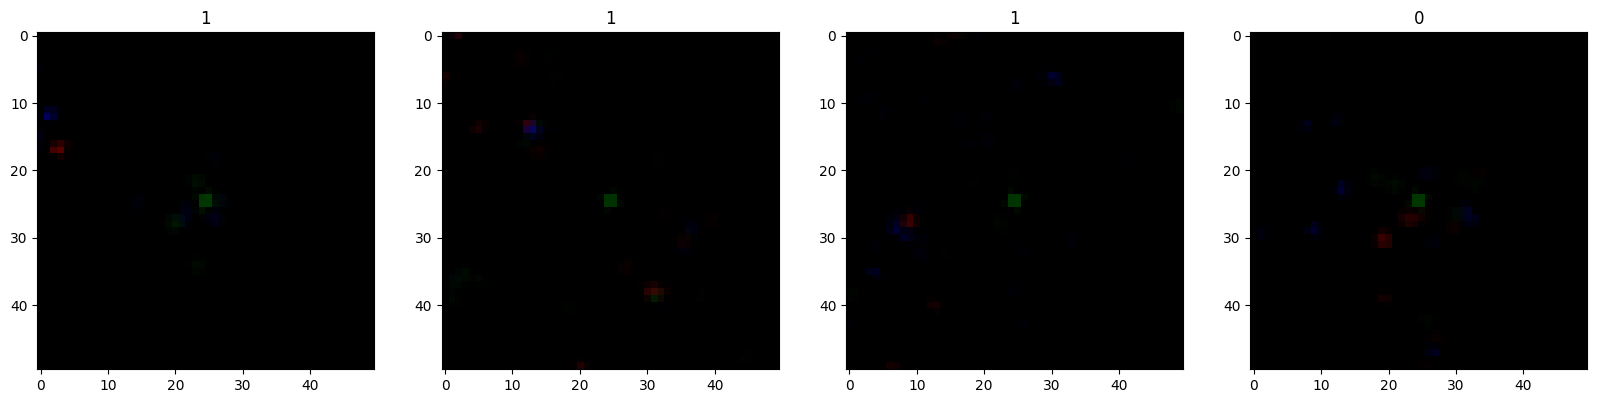

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


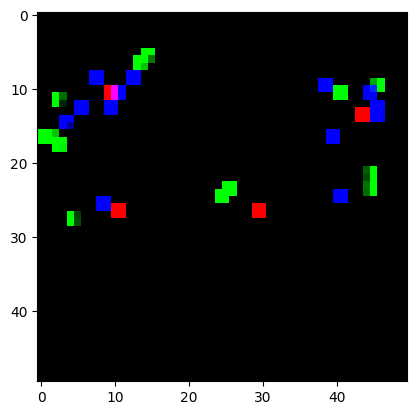

In [10]:
data_batch = data.as_numpy_iterator().next()
sample_img =data_batch[0][4]
plt.imshow(sample_img)
plt.show()

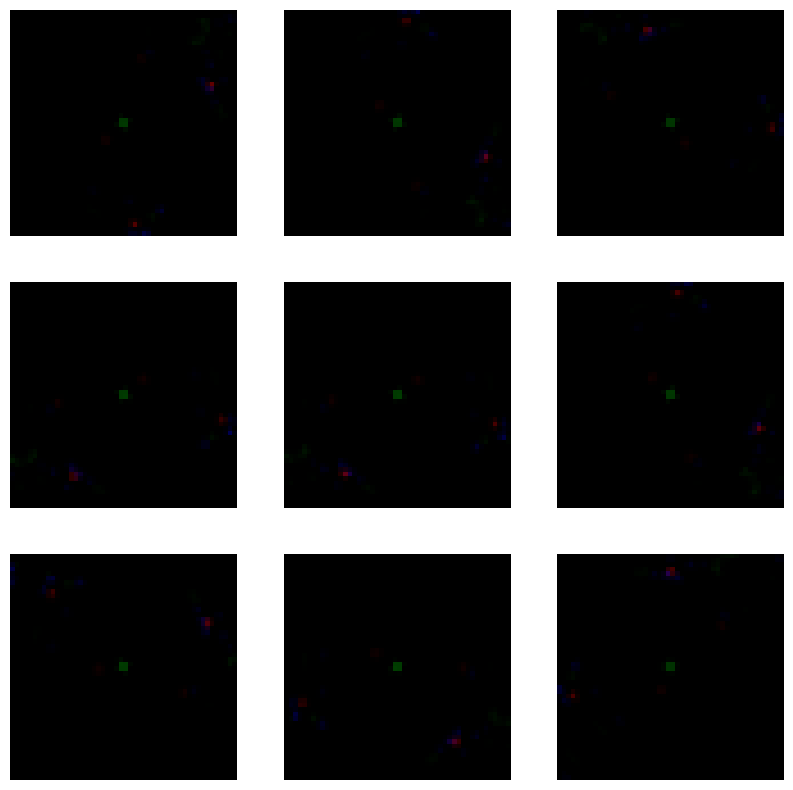

In [12]:
#Augmented sample_img
image = tf.cast(tf.expand_dims(sample_img, 0), tf.float32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# Model

In [13]:
AugData_model = Sequential()

AugData_model.add(Conv2D(128, (5,5), 1, padding = 'same', activation='relu', input_shape=(50,50,3)))
AugData_model.add(AveragePooling2D(pool_size = (2,2),strides=1)) #2x2 filter

AugData_model.add(Conv2D(256, (3,3), 1, activation='relu'))
AugData_model.add(AveragePooling2D(pool_size = (2,2)))

AugData_model.add(Conv2D(64, (3,3), 1, activation='relu'))
AugData_model.add(AveragePooling2D(pool_size = (2,2), strides=1,
                        padding='same'))

AugData_model.add(Conv2D(16, (2,2), 1, activation='relu'))
AugData_model.add(AveragePooling2D(pool_size = (2,2)))

AugData_model.add(Conv2D(8, (2,2), 1, activation='relu'))
AugData_model.add(AveragePooling2D(pool_size = (2,2)))

AugData_model.add(Flatten())

AugData_model.add(Dense(256, activation='relu'))
AugData_model.add(Dense(512, activation='relu'))
AugData_model.add(Dense(1, activation='sigmoid'))

In [14]:
AugData_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 49, 49, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 23, 23, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 21, 21, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 16)     │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 10, 10, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 4, 4, 8)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,169 (2.37 MB)

 Trainable params: 622,169 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
AugData_model.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [ ]:
logdir = 'EFlow Images/AugData_model_logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist_AugData_model = AugData_model.fit(train,
                 epochs = 30,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/30


I0000 00:00:1722590957.306806    2376 service.cc:145] XLA service 0x9029e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722590957.307100    2376 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-02 09:29:17.431233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-02 09:29:17.889697: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1722590969.566810    2376 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 316ms/step - accuracy: 0.5206 - auc: 0.5190 - false_negatives: 1964.2391 - false_positives: 1307.7971 - loss: 0.6889 - precision: 0.5009 - recall: 0.3450 - true_negatives: 2198.7898 - true_positives: 1478.4492 - val_accuracy: 0.5023 - val_auc: 0.5000 - val_false_negatives: 0.0000e+00 - val_false_positives: 1941.0000 - val_loss: 295.5172 - val_precision: 0.5023 - val_recall: 1.0000 - val_true_negatives: 0.0000e+00 - val_true_positives: 1959.0000
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6180 - auc: 0.6526 - false_negatives: 1780.7102 - false_positives: 859.4203 - loss: 0.6494 - precision: 0.6566 - recall: 0.4697 - true_negatives: 2653.4709 - true_positives: 1655.6740 - val_accuracy: 0.5023 - val_auc: 0.4998 - val_false_negatives: 24.0000 - val_false_positives: 1917.0000 - val_loss: 209.8762 - val_precision: 0.5026 - val_recall: 0.9878 - val_true_negatives: 22.0000 - val_true_positives: 1937.0000
Epoch 3/30
137/137 ━━━━━━━━━━━━━━

In [ ]:
model = load_model("")